# 运用BP神经网络识别“猫”

In [67]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from pylab import *
from lr_utils import load_dataset

In [2]:
%matplotlib inline

## 查看h5文件中dataset的数据

In [3]:
import h5py

f = h5py.File('datasets/test_catvnoncat.h5', 'r')
for key in f.keys():
    print(f[key], key, f[key].name)

<HDF5 dataset "list_classes": shape (2,), type "|S7"> list_classes /list_classes
<HDF5 dataset "test_set_x": shape (50, 64, 64, 3), type "|u1"> test_set_x /test_set_x
<HDF5 dataset "test_set_y": shape (50,), type "<i8"> test_set_y /test_set_y


h5文件中有两个核心的概念：组“group”和数据集“dataset”。 一个h5文件就是 “dataset” 和 “group” 二合一的容器。

dataset ：简单来讲类似数组组织形式的数据集合，像numpy数组一样工作，一个dataset即一个numpy.ndarray。具体的dataset可以是图像、表格，甚至是pdf文件和excel。

group：包含了其它 dataset(数组) 和 其它 group ，像字典一样工作。

一个h5文件被像linux文件系统一样被组织起来：dataset是文件，group是文件夹，它下面可以包含多个文件夹(group)和多个文件(dataset)。

In [4]:
classes_group = f["list_classes"]
classes_group[:]

array([b'non-cat', b'cat'], dtype='|S7')

In [5]:
testset_x = f["test_set_x"]
testset_y = f["test_set_y"]

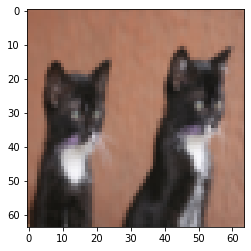

In [6]:
imshow(testset_x[0])

In [7]:
testset_y[0]

1

# 从lr_utils导入数据集

In [8]:
# load dataset from lr_utils file
train_set_x_orig,train_set_y,test_set_x_orig,test_set_y,classes = load_dataset()

## 查看训练集的数据

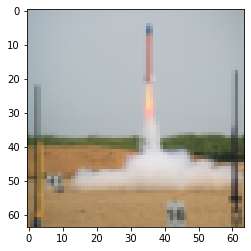

In [9]:
index = 22
plt.imshow(train_set_x_orig[index])
#print("train_set_y=" + str(train_set_y))  查看训练集里的标签

In [10]:
train_set_x_orig[0].shape #图片数组的形状

(64, 64, 3)

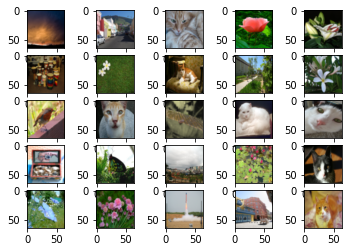

In [11]:
# 打印前25张图片
_, axes = plt.subplots(5,5)
axes = [item for subl in axes for item in subl]

for i, ax in enumerate(axes):
    img = train_set_x_orig[i]#.reshape((28,28))
    ax.imshow(img, cmap="gray");

In [12]:
train_set_y.shape

(1, 209)

In [13]:
# 查看图片的label
print("y=" + str(train_set_y[:,index]) + ",it's a " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "' picture")

y=[0],it's a non-cat' picture


## 变量名定义

m_train ：训练集里图片的数量。

m_test ：测试集里图片的数量。

num_px ： 训练、测试集里面的图片的宽度和高度（均为64x64）。

train_set_x_orig 是一个维度为(m_​​train，num_px，num_px，3）的数组。

In [14]:
m_train = train_set_y.shape[1] #训练集里图片的数量。
m_test = test_set_y.shape[1] #测试集里图片的数量。
num_px = train_set_x_orig.shape[1] #训练、测试集里面的图片的宽度和高度（均为64x64）。

#输出看结果
print("训练集的数量 : m_train = " + str(m_train))
print("测试集的数量 : m_test = " + str(m_test))
print("每张图片的宽/高 : num_px = " + str(num_px))
print("每张图片的大小 : (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("训练集_图片的维数 : " + str(train_set_x_orig.shape))
print("训练集_标签的维数 : " + str(train_set_y.shape))
print("测试集_图片的维数 : " + str(test_set_x_orig.shape))
print("测试集_标签的维数 : " + str(test_set_y.shape))

训练集的数量 : m_train = 209
测试集的数量 : m_test = 50
每张图片的宽/高 : num_px = 64
每张图片的大小 : (64, 64, 3)
训练集_图片的维数 : (209, 64, 64, 3)
训练集_标签的维数 : (1, 209)
测试集_图片的维数 : (50, 64, 64, 3)
测试集_标签的维数 : (1, 50)


## Numpy的降维
为了方便，我们要把维度为（64，64，3）的numpy数组重新构造为（64 x 64 x 3，1）的数组，要乘以3的原因是每张图片是由64x64像素构成的，

而每个像素点由（R，G，B）三原色构成的，所以要乘以3。在此之后，我们的训练和测试数据集是一个numpy数组，【每列代表一个平坦的图像】 ，应该有m_train和m_test列。

将形状（a，b，c，d）的矩阵X平铺成形状（b * c * d，a）的矩阵X_flatten：

In [15]:
# X_flatten = X.shape(X.shape[0],-1).T 
#将训练集的维度降低并转置。
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
#将测试集的维度降低并转置。
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

In [16]:
print ("训练集降维之后的维度： " + str(train_set_x_flatten.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print ("测试集_标签的维数 : " + str(test_set_y.shape))

训练集降维之后的维度： (12288, 209)
训练集_标签的维数 : (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数 : (1, 50)


## RGB像素数据标准化
为了表示彩色图像，必须为每个像素指定红色，绿色和蓝色通道（RGB），因此像素值实际上是从0到255范围内的三个数字的向量。

常见的数据预处理步骤是对数据集进行居中和标准化，这意味着可以减去每个示例中整个numpy数组的平均值，然后将每个示例除以整个numpy数组的标准偏差。

但对于图片数据集，它更简单，更方便，几乎可以将数据集的每一行除以255（像素通道的最大值），因为在RGB中不存在比255大的数据，

所以可以除以255，让标准化的数据位于[0,1]之间，现在标准化数据集：

In [17]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

# 开始构建BP神经网络。

## 建立神经网络的主要步骤 
1. 定义模型结构（例如输入特征的数量） 
2. 初始化模型的参数 
3. 循环：
  
  3.1 计算当前损失（正向传播）

  3.2 计算当前梯度（反向传播）

  3.3 更新参数（梯度下降）

## 定义Sigmoid函数
首先定义Sigmoid()函数，
$$\cases{\sigma(z) = \frac{1}{1+e^{-z}},\\z=\omega^Tx+b}$$
后面需要使用Sigmoid$(\omega ^ T x + b)$计算来做出预测。

In [18]:
def sigmoid(z):
    """
    参数:
        z - 任何大小的标量或numpy数组。
        
    返回：
        s - sigmoid(z)
    """
    s = 1 / (np.exp(-z) + 1)
    return s

测试一下Sigmoid()，检查一下是否符合我们所需要的条件。

In [19]:
# test sigmoid()
print("===== test sigmoid =====")
print("sigmoid(0) = " + str(sigmoid(0)))
print("sigmoid(-1) = " + str(sigmoid(-1)))
print("sigmoid([1,2]) = " + str(sigmoid(np.array([1,2]))))

===== test sigmoid =====
sigmoid(0) = 0.5
sigmoid(-1) = 0.2689414213699951
sigmoid([1,2]) = [0.73105858 0.88079708]


## 初始化参数$\omega$和b。

In [20]:
def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。

        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）

        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros(shape = (dim,1))
    b = 0
    #使用assert来确保我要的数据是正确的
    assert(w.shape == (dim,1)) #w的维度是（dim,1）
    assert(isinstance(b,float) or isinstance(b,int)) #b的类型是float或者是int
    
    return(w , b)

## 定义反向传播函数

交叉熵成本函数cross-entropy：
$$J(\omega, b)=-\frac{1}{m} \sum\limits_x [y\text{ln}a + (1-y)\text{ln}(1-a)]$$
其中，$m$为样本数，$x$表示样本，$y$表示样本值，$a=\sigma(\omega^Tx+b)$为激活函数值。

对于前面提到的Sigmoid函数，有
$$\begin{aligned}
\frac{d\sigma(z)}{dz}&=\frac{e^{-z}}{(1+e^{-z})^2}\\&=\sigma(z)(1-\sigma(z))
\end{aligned}$$
那么，有成本函数对$\omega$和$b$的导数为
$$\begin{aligned}
\frac{\partial}{\partial \omega}J(\omega, b)&=\frac{\partial J}{\partial a}\cdot\frac{\partial a}{\partial z}\\
&=-\frac{1}{m}\sum\limits_x[y\cdot\frac{1}{a}a(1-a)\cdot x^T + (1-y)\cdot(-\frac{1}{1-a})(1-a)a\cdot x^T\\
&=-\frac{1}{m}\sum\limits_x[y(1-a)x^T+(1-y)(-a)x^T]\\
&=\frac{1}{m}\sum\limits_x[(a-y)x^T]
\end{aligned}$$
$$\begin{aligned}
\frac{\partial}{\partial \omega}J(\omega, b)&=\frac{\partial J}{\partial a}\cdot\frac{\partial a}{\partial b}\\
&=-\frac{1}{m}\sum\limits_x[y\cdot\frac{1}{a}a(1-a)+ (1-y)\cdot(-\frac{1}{1-a})(1-a)a\\
&=-\frac{1}{m}\sum\limits_x[y(1-a)+(1-y)(-a)]\\
&=\frac{1}{m}\sum\limits_x (a-y)
\end{aligned}$$

In [21]:
def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]
    
    #正向传播
    A = sigmoid(np.dot(w.T,X) + b) #计算激活函数值 
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1-A))) #计算成本
    
    #反向传播
    dw = (1 / m) * np.dot(X,(A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    #使用断言确保数据是正确的
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    #creat a dictionary to store dw and db
    grads = {
                "dw": dw,
                "db": db
            }
    return (grads , cost)

测试一下

In [22]:
#测试一下propagate
print("====================测试propagate====================")
#初始化一些参数
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

====================测试propagate====================
dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


## 使用梯度下降更新参数

目标是通过最小化成本函数$J$来学习$\omega$和$b$。对于参数$\theta$，更新规则是$$\theta_i:=\theta_i−\alpha\frac{\partial J}{\partial \theta_i}, i=0,1$$
其中，在本例中$\theta_0=\omega,\theta_1=b$

In [23]:
def optimize(w , b , X , Y , num_iterations , learning_rate , print_cost = False):
    """
    此函数通过运行梯度下降算法来优化w和b

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值

    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        costs - 优化期间计算的所有成本列表，将用于绘制学习曲线。

    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """
    
    costs = []
    ws = []
    bs = []
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ws.append(w)
        bs.append(b)
        
        #record cost
        if i % 100 == 0:
            costs.append(cost)
        #print cost data
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: % i , 误差值: %f" % (i,cost))
            
    params = {
                "w" : w,
                "b" : b }
    grads = {
                "dw" : dw,
                "db" : db,
                "ws" : ws,
                "bs" : bs}
    return(params , grads , costs, ws, bs)

测试一下

In [24]:
#test optimize
print("===== test optimize =====")
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
params , grads , costs, ws, bs= optimize(w , b , X , Y , num_iterations = 100 , learning_rate = 0.09 , print_cost = False)
print("w = " + str(params["w"]))
print("b = " + str(params["b"]))
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))
#print("ws = " + str(grads["ws"]))
#print("bs = " + str(grads["bs"]))

===== test optimize =====
w = [[-0.98778642]
 [-0.19158085]]
b = 1.8981027842897988
dw = [[ 0.09247419]
 [-0.02390367]]
db = -0.05818892715848467


## 实现预测函数predict()
计算预测有两个步骤：

计算Sigmoid函数的激活值，$Y=A=\sigma(\omega^TX+b)$
将$a$的值变为0（如果激活值$\le0.5$）或者为1（如果激活值$> 0.5$）
$$\begin{aligned}
A=\cases{0,\quad \text{if}\  a\le 0.5\\
1,\quad \text{else}}
\end{aligned}$$

然后将预测值存储在向量Y_prediction中。

In [25]:
def predict(w , b , X):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据

    返回：
        Y_prediction  - 包含X中所有图片的所有预测[0 | 1]的一个numpy数组（向量）

    """
    
    m = X.shape[1]#number of images
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    #计预测猫在图片中出现的概率
    
    A = sigmoid(np.dot(w.T,X) + b)
    for i in range(A.shape[1]):
        
        #将概率a[0,i]转换为实际预测p[0,i]
        
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
        
    #使用断言
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [26]:
#test prediction
print("===== test prediction =====")
w, b, X, Y = np.array([[1],[2]]),2,np.array([[1,2],[3,4]]),np.array([[1,0]])
print("predictions = " + str(predict(w , b , X)))

===== test prediction =====
predictions = [[1. 1.]]


# 定义主函数构建逻辑回归模型

In [27]:
def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False):
    """
    通过调用之前实现的函数来构建逻辑回归模型

    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的参数
        print_cost  - 设置为true以每100次迭代打印成本

    返回：
        d  - 包含有关模型信息的字典。
    """
    w , b = initialize_with_zeros(X_train.shape[0])
    
    parameters , grads , costs, ws, bs= optimize(w , b , X_train , Y_train , num_iterations , learning_rate , print_cost)
    
    #find parameters w and b from dict.params
    w , b = parameters["w"] , parameters["b"]
    
    #预测测试/训练集的例子
    Y_prediction_test = predict(w , b , X_test)
    Y_prediction_train = predict(w , b , X_train)
    
    #打印训练后的准确性
    print("训练集的准确性: " , format(100 - np.mean(np.abs(Y_prediction_train - Y_train))*100),"%")
    print("测试集的准确性: " , format(100 - np.mean(np.abs(Y_prediction_test - Y_test))*100),"%")
    
    d = {
            "costs" : costs,
            "Y_prediction_test" : Y_prediction_test,
            "Y_prediction_train" : Y_prediction_train,
            "w" : w,
            "b" : b,
            "learning_rate" : learning_rate,
            "num_iterations" : num_iterations,
            "ws" : ws,
            "bs" : bs 
        }
    return d

## 开始运行模型

In [28]:
print("===== test model =====")
#此处加载真实数据
d = model(train_set_x , train_set_y , test_set_x , test_set_y , num_iterations = 2000 , learning_rate = 0.005 , print_cost = True)

===== test model =====
迭代的次数:  0 , 误差值: 0.693147
迭代的次数:  100 , 误差值: 0.584508
迭代的次数:  200 , 误差值: 0.466949
迭代的次数:  300 , 误差值: 0.376007
迭代的次数:  400 , 误差值: 0.331463
迭代的次数:  500 , 误差值: 0.303273
迭代的次数:  600 , 误差值: 0.279880
迭代的次数:  700 , 误差值: 0.260042
迭代的次数:  800 , 误差值: 0.242941
迭代的次数:  900 , 误差值: 0.228004
迭代的次数:  1000 , 误差值: 0.214820
迭代的次数:  1100 , 误差值: 0.203078
迭代的次数:  1200 , 误差值: 0.192544
迭代的次数:  1300 , 误差值: 0.183033
迭代的次数:  1400 , 误差值: 0.174399
迭代的次数:  1500 , 误差值: 0.166521
迭代的次数:  1600 , 误差值: 0.159305
迭代的次数:  1700 , 误差值: 0.152667
迭代的次数:  1800 , 误差值: 0.146542
迭代的次数:  1900 , 误差值: 0.140872
训练集的准确性:  99.04306220095694 %
测试集的准确性:  70.0 %


In [29]:
ws = d["ws"]
bs = d["bs"]
w = d["w"]
b = d["b"]

In [30]:
w0 = np.array(ws[0]*255).reshape(64,64,3)
w1 = np.array(ws[499]*255).reshape(64,64,3)
w2 = np.array(ws[999]*255).reshape(64,64,3)
w3 = np.array(ws[1499]*255).reshape(64,64,3)
w4 = np.array(ws[1999]*255).reshape(64,64,3)
w5 = np.array(w*255).reshape(64,64,3)
ww = [w0,w1,w2,w3,w4,w5]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


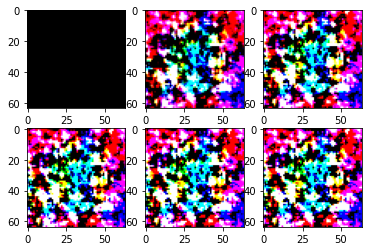

In [31]:
_, axes = plt.subplots(2,3)
axes = [item for subl in axes for item in subl]

for i, ax in enumerate(axes):
    img = ww[i]#.reshape((28,28))
    ax.imshow(img, cmap="gray");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


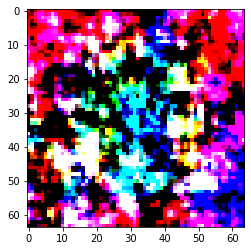

In [32]:
#plot ws
imshow(w1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


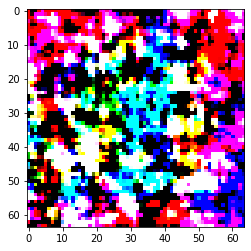

In [33]:
imshow(w5)

## 结果分析

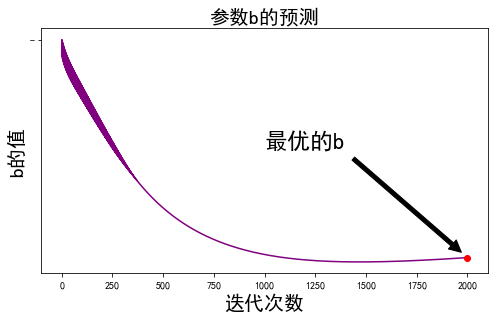

In [34]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
figsize = 8, 4.5
figure, ax = plt.subplots(figsize=figsize)
ax.plot(range(len(bs)),bs[:],'purple','-')
ax.plot(2000,b,'ro')
#plt.text(2000, b, str(b.round(6)), ha='center', va='bottom', fontsize=14)
font1 = {'family' : 'Times New Roman','weight' : 'normal','size'   : 23}
ax.annotate('最优的b',xy=(2000,b),xytext=(1000,0.5*b),arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 23)
plt.title('参数b的预测',fontsize = 20)
plt.xlabel('迭代次数',fontsize = 20)
plt.ylabel('b的值',fontsize = 20)
plt.savefig('iter_b.svg', dpi = 250)
plt.show()

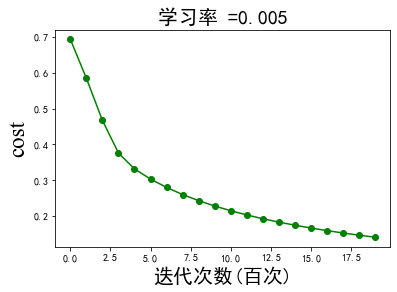

In [35]:
#绘制图
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
costs = np.squeeze(d['costs'])
plt.plot(costs,'go-')
plt.ylabel('cost',font1)
plt.xlabel('迭代次数(百次)',fontsize=20)
plt.title("学习率 =" + str(d["learning_rate"]),fontsize=20)
plt.show()

可以看出，随着迭代的增加，成本函数的值在下降（收敛）

### 比较一下不同learning rate对cost function的影响

learning rate is: 0.02
训练集的准确性:  100.0 %
测试集的准确性:  68.0 %

--------------------------------------------

learning rate is: 0.01
训练集的准确性:  99.52153110047847 %
测试集的准确性:  68.0 %

--------------------------------------------

learning rate is: 0.001
训练集的准确性:  88.99521531100478 %
测试集的准确性:  64.0 %

--------------------------------------------

learning rate is: 0.0001
训练集的准确性:  68.42105263157895 %
测试集的准确性:  36.0 %

--------------------------------------------



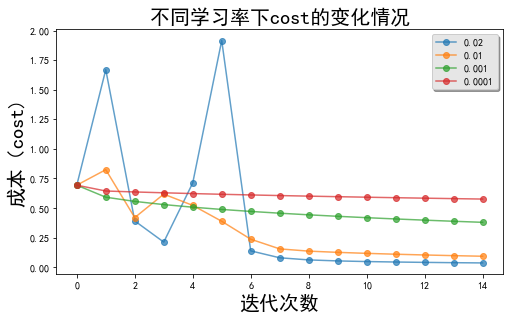

In [36]:
learning_rates = [0.02,0.01, 0.001, 0.0001]
models = {}
figsize = 8, 4.5
figure= plt.subplots(figsize=figsize)
for i in learning_rates:
    print("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print('\n' + "--------------------------------------------" + '\n')
    
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]),'o-',alpha=0.7,label = str(models[str(i)]["learning_rate"]))


plt.ylabel('成本（cost)',fontsize=20)
plt.xlabel('迭代次数',fontsize=20)
plt.title("不同学习率下cost的变化情况",fontsize=20)

legend = plt.legend(loc = 'upper right', shadow = True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.savefig('different learning rate.svg', dpi=250)
plt.show()

- 可以看出learning rate并不一定是越小越好，或者越大越好，找到合适的learning rate会对算法的成本函数的收敛至关重要。
**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 


y = 1.0, your algorithm predicts a "cat" picture.


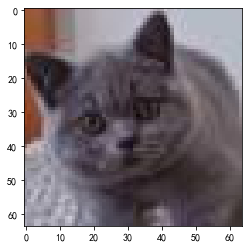

In [110]:
from matplotlib.pyplot import imread
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "my_image1.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
# fname = "images/" + my_image
image = np.array(imread(my_image, format=None))
num_px1 = image.shape[0]
num_px2 = image.shape[1]
my_image = resize(image,(1, num_px1*num_px2*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")